# A Chinese NLP Study based on Douban Movie Reviews
# 豆瓣电影评论文本分析

## Contents

- [Background](#Background)
- [Problem Statement](#Problem-Statement)
- [Data Cleaning & EDA](#Data-Cleaning-and-EDA)
- [Preprocessing & Modeling](#Preprocessing-&-Modeling) 
- [Prediction](#Prediction)
- [Conclusion and Recommendation](#Conclusion-and-Recommendation)
- [References](#References)

## Background

#### About [Douban](https://www.douban.com/) review website:

Douban is a popular social networking and review platform in China where users can share their opinions and ratings on various topics, including movies. Douban movie reviews are typically written by users who have watched a particular movie and want to share their thoughts and feelings about it.

Douban movie reviews often include a brief synopsis of the movie, along with the reviewer's opinion on the acting, plot, cinematography, and overall quality of the film. Users can rate movies on a scale of 1-10, and the site aggregates these scores to create an overall rating for each movie.

One interesting aspect of Douban movie reviews is that they often reflect the views and tastes of Chinese audiences, which can differ from those of Western audiences. For example, Chinese audiences may have different cultural references and expectations for certain genres of movies. - By ChatGPT

## Problem Statement

The objective of the study is two folds:

#### 1. Proof of Concept: 
Is the analysis through text EDA & NLP able to uncover the linguistic complexity and cultural nuances of Chinese, by a test of movie genre classification?

#### 2. Insights for Douban:
For movie reviews under two different genres, how far apart are their Douban reviews? 


The project is approached with the following steps:

## Data Collection

In [1]:
# install and import all the libraries needed for this project:
import requests
import json
import re
import os
import bs4
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import jieba.posseg as pseg
import jieba
import jieba.analyse
from jieba import analyse
import stopwordsiso
from stopwordsiso import stopwords
import pandas as pd
import numpy as np
import time
from requests.exceptions import RequestException
import seaborn as sns
import scattertext as st
import spacy
from scattertext import SampleCorpora, PhraseMachinePhrases, dense_rank, RankDifference, AssociationCompactor, produce_scattertext_explorer
from scattertext.CorpusFromPandas import CorpusFromPandas
import zh_core_web_sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, plot_confusion_matrix, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse.linalg import svds
from snownlp import SnowNLP
from collections import Counter
from sklearn import metrics

#### The following scraper code is learnt from [HERE](https://codeantenna.com/a/UbO268F9RD).

In [2]:
def get_html(url):
    """set Cookies, Url, user-agent, headers"""
    
    headers = {
        "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                      "AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36 Edg/91.0.864.67"
    }
    
    try:
        r = requests.get(url=url, headers=headers, timeout=30)
        r.encoding = r.apparent_encoding
        status = r.status_code   

        data = json.loads(r.text)["html"]
        str_html = "<html>{}</html>".format(data)
        html = BeautifulSoup(str_html, "html.parser")

        print("Response Status Code" + str(status))
        
        # print(type(html))
        
        return html
    except Exception as e:
        print("Failed to scrape")
        print(e)

def etl_data(html):
    """to extract the data needed"""

    # save all the users' comments into a list, .find_all is compatible for data in <class 'bs4.BeautifulSoup'> format
    comments = html.find_all('div', 'comment-item')
    # print(comments[0])

    # save the data into a list:
    data = []

    for span in comments:
        # data and time of the comment:
        time = span.find('span', 'comment-time').attrs['title']
        # user name:
        user = span.find('a').attrs["title"]
        # rating in stars:
        # .attrs['class'][0][-2:]to get the number of stars:
        try:
            rating = span.find('span', 'rating').attrs['class'][0][-2:]
            if (rating == '10'):
                rating = "1"
            elif (rating == '20'):
                rating = "2"
            elif (rating == '30'):
                rating = "3"
            elif (rating == '40'):
                rating = "4"
            elif (rating == '50'):
                rating = "5"
        except Exception as e:
            # if the rating is empty, set it as "0"
            rating = "0"

        # .strip() to remove space in between lines
        comment = span.find('span', 'short').string.strip()
        # delete the '\n' in between lines
        comment = re.sub(r'\n', '', comment)

        # number of votes for each comment:
        votes = span.find('span', 'vote-count').string.strip()

        arr = [time, user, rating, comment, votes]
        data.append(arr)

        df = pd.DataFrame(data)
        df.columns = ["time", "user", "rating", "comment", "votes"]

        # print(arr)
    return df

def get_nextUrl(html):
    """get url"""

    try:
        # get the url of the next page
        url = html.find('a', 'next').attrs['href']
        # print(url)
        next_start = re.search(r'[0-9]\d{0,5}', url).group(0)
        print("Now at " + str(next_start) + " Please wait...\n")

        # find the target movie comment page url:
        next_url = "https://movie.douban.com/subject/35267208/comments?percent_type=" \
                   "&start={}&limit=200&status=P&sort=new_score&comments_only=1&ck=Cuyu".format(next_start)
        # print(next_url)

        return next_url
    except:
        print("End of comments")


def save_data(data, fileName, Flag):
    """save data"""

    file_name = fileName + "_" + time.strftime("%Y_%m_%d", time.localtime(time.time())) + ".csv"
    # print(file_name)

    # 存储为csv格式文件
    data.to_csv(file_name, index=False, header=Flag, mode='a', encoding="utf_8_sig")

    # 检查是否保存成功，并打印提示文本
    if os.path.exists(file_name):
        print(file_name + " Data saved.")
    else:
        print('Failed to save data')

if __name__ == "__main__":
    """entry point"""

    # the target url
    url = "https://movie.douban.com/subject/35267208/comments?percent_type=" \
          "&start={}&limit=200&status=P&sort=new_score&comments_only=1&ck=Cuyu".format(0)

    html = get_html(url)
    data = etl_data(html)

    fileName = input("Name the file as:")
    save_data(data, fileName, True)

    next_url = get_nextUrl(html)

    isFlag = True
    while(next_url):
        try:
            next_html = get_html(next_url)
            next_data = etl_data(next_html)
            save_data(next_data, fileName, False)
            next_url = get_nextUrl(next_html)
        except:
            break;

Response Status Code200


Name the file as: test


test_2023_03_18.csv Data saved.
Now at 200 Please wait...

Response Status Code200
test_2023_03_18.csv Data saved.
Now at 400 Please wait...

Response Status Code200
test_2023_03_18.csv Data saved.
Now at 600 Please wait...

Failed to scrape
Expecting value: line 1 column 1 (char 0)


It is noticed that Douben has implemented a guardrail to avoid people from craping more than 520 comments per each movie title. In order to get increase the data size for my study, I have selected two genres with 6 titles each. The genres selected are **Sci-fi Movies** and **Stephen Chow** Movies. Within each genre, the titles are as similar as possible. 

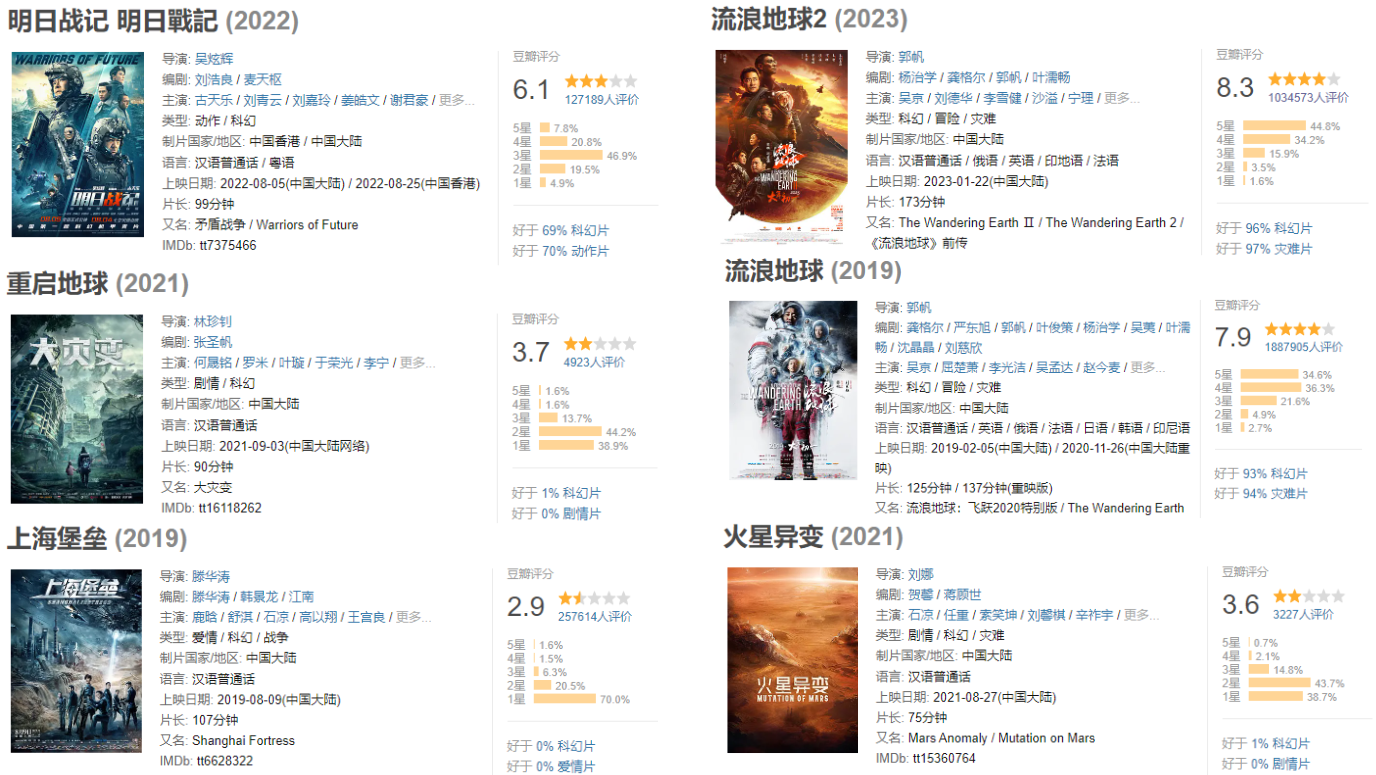

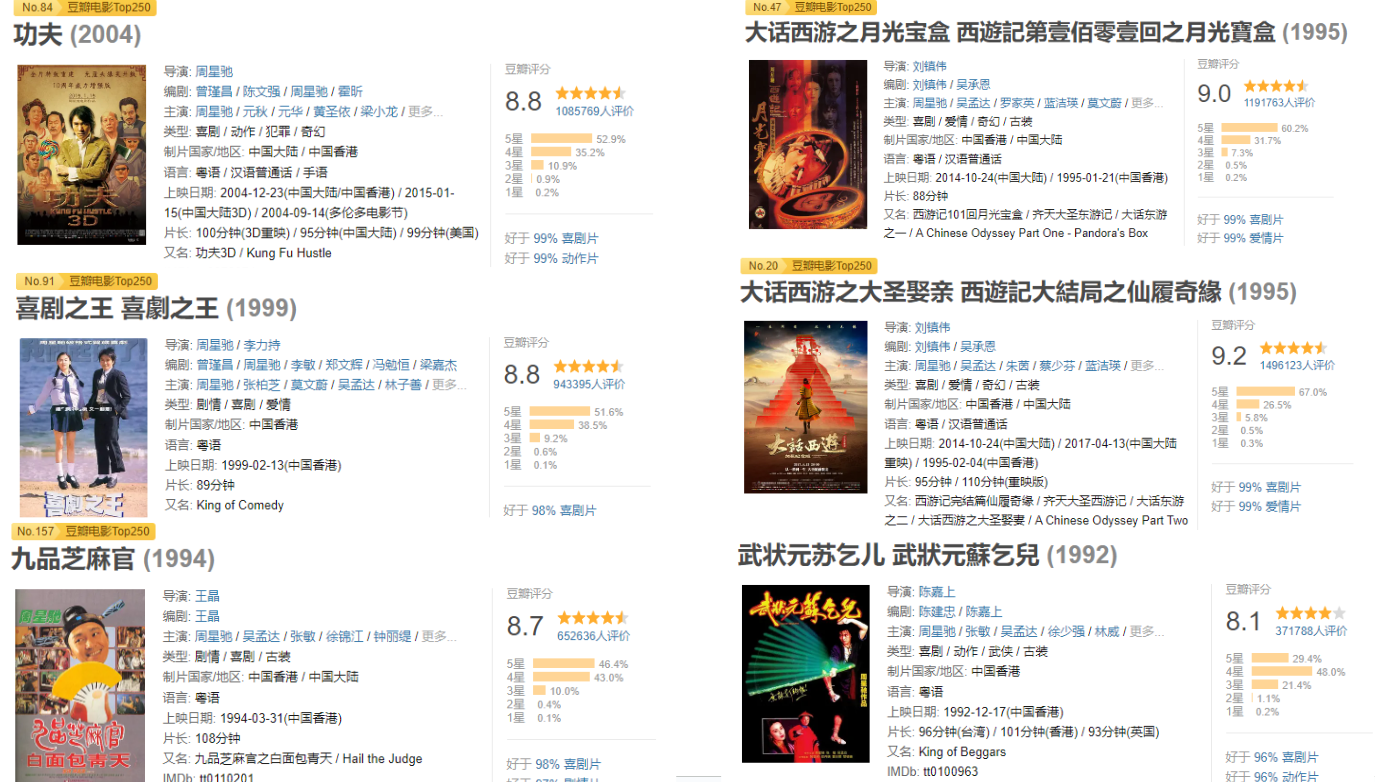

For each of the above titles, I searched it through the Douban homepage, clicked to view its reviews and got the review page URL. By inputting the target page URL into the craper code, I managed to get the first 520 comments for each movie and saved them into individual files in .csv format.

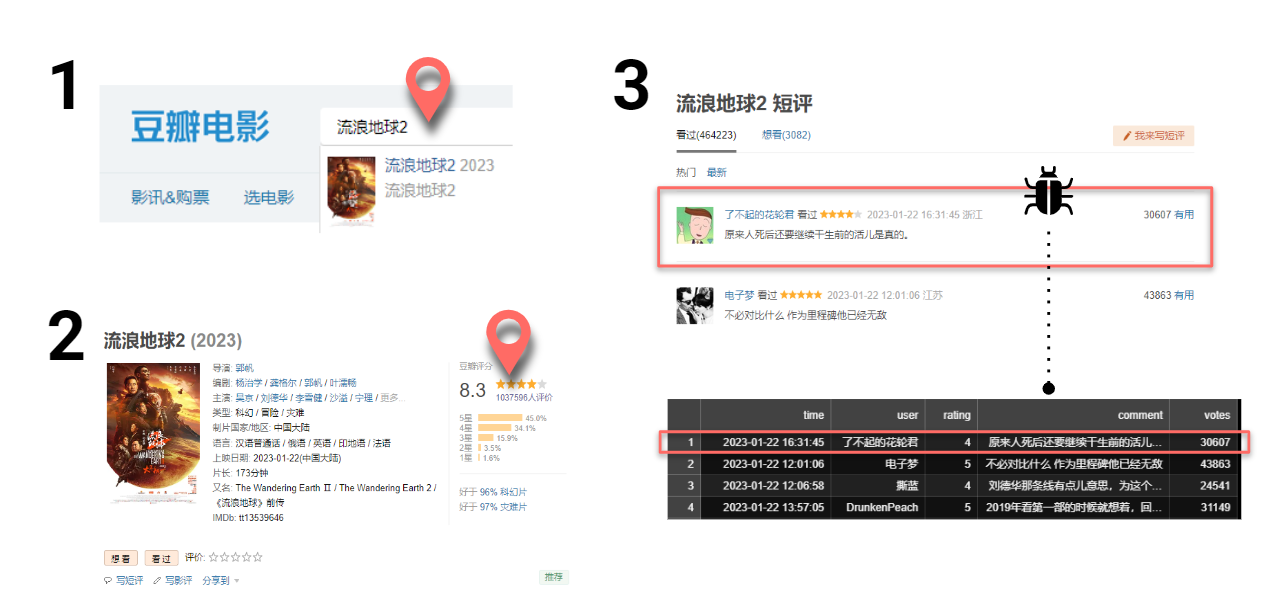

## Data Cleaning & EDA

In [2]:
# read the sci-fi movie review data (6 files from 6 titles):
df_earth1 = pd.read_csv('./data/earth1_2023_03_11.csv')
df_earth2 = pd.read_csv('./data/earth2_2023_03_05.csv')
df_fortress = pd.read_csv('./data/fortress_2023_03_11.csv')
df_future = pd.read_csv('./data/future_2023_03_11.csv')
df_mars = pd.read_csv('./data/mars_2023_03_11.csv')
df_reset = pd.read_csv('./data/reset_2023_03_11.csv')

# read the comedy movie review data (6 files from 6 titles):
df_beggar = pd.read_csv('./data/beggar_2023_03_11.csv')
df_comedy = pd.read_csv('./data/comedy_2023_03_11.csv')
df_gongfu = pd.read_csv('./data/gongfu_2023_03_11.csv')
df_judge = pd.read_csv('./data/judge_2023_03_11.csv')
df_xiyou1 = pd.read_csv('./data/xiyou1_2023_03_11.csv')
df_xiyou2 = pd.read_csv('./data/xiyou2_2023_03_11.csv')

In [3]:
# combine files into two target genres:
df_scifi = pd.concat([df_earth1, df_earth2, df_fortress, df_future, df_mars, df_reset],axis=0 )
df_chow = pd.concat([df_beggar, df_comedy, df_gongfu, df_judge, df_xiyou1, df_xiyou2],axis=0 )

In [4]:
# look at the shape of the dataframes:
df_scifi.shape

(3120, 5)

In [5]:
df_chow.shape

(3120, 5)

In [6]:
# take a look at the headers:
df_scifi.head()

time  user  rating  \
0  2019-02-04 15:56:16    影志       4   
1  2019-01-27 14:16:11   朝暮雪       4   
2  2019-02-02 14:29:09  亵渎电影       4   
3  2019-02-07 02:27:52    琦殿       4   
4  2019-01-29 02:11:13   张小北       5   

                                             comment  votes  
0  “北京道路安全委提醒你：道路千万条，安全第一条，行车不规范，亲人两行泪” 这句广播语真是又土...  74094  
1  《流浪地球》小说本就想象力丰富，让地球连同地球人一同逃难的创意荡气回肠、惊艳无比。电影中的行...  14308  
2  中国导演能拍出这样的硬科幻，看到这样的完成度，想想就激动，可以让人原谅一切不完美！说这部电影...  10220  
3                           刘启韩朵朵，地球给你俩了，毁灭吧，赶紧的，累了。   3292  
4  从各个方面来说都是一部好看的类型片。而最特别的是它是一部国产科幻电影，影迷+科幻迷的双重满足...  14424

In [7]:
df_scifi.head()

time  user  rating  \
0  2019-02-04 15:56:16    影志       4   
1  2019-01-27 14:16:11   朝暮雪       4   
2  2019-02-02 14:29:09  亵渎电影       4   
3  2019-02-07 02:27:52    琦殿       4   
4  2019-01-29 02:11:13   张小北       5   

                                             comment  votes  
0  “北京道路安全委提醒你：道路千万条，安全第一条，行车不规范，亲人两行泪” 这句广播语真是又土...  74094  
1  《流浪地球》小说本就想象力丰富，让地球连同地球人一同逃难的创意荡气回肠、惊艳无比。电影中的行...  14308  
2  中国导演能拍出这样的硬科幻，看到这样的完成度，想想就激动，可以让人原谅一切不完美！说这部电影...  10220  
3                           刘启韩朵朵，地球给你俩了，毁灭吧，赶紧的，累了。   3292  
4  从各个方面来说都是一部好看的类型片。而最特别的是它是一部国产科幻电影，影迷+科幻迷的双重满足...  14424

In [8]:
# check for missing values:
df_scifi.isnull().sum()

time       0
user       3
rating     0
comment    0
votes      0
dtype: int64

In [9]:
df_chow.isnull().sum()

time       0
user       0
rating     0
comment    0
votes      0
dtype: int64

In [10]:
# fill the empty cells of "user" columns with name "unknown":
df_scifi['user'] = df_scifi['user'].fillna('unknown')

#### Discover the ratings of the two genres:

In [11]:
print(f'The average rating for Sci-fi movies is: {df_scifi.rating.mean()}')
print(f'The average rating for Stephen Chow movies is: {df_chow.rating.mean()}')

The average rating for Sci-fi movies is: 2.4612179487179486
The average rating for Stephen Chow movies is: 4.196153846153846


In [12]:
# create a new column 'scifi' to hold a binary value for each genre and combine the two datasets:
df_scifi['scifi']= 1
df_chow['scifi']= 0
df_merge = pd.concat([df_scifi, df_chow],axis=0 )

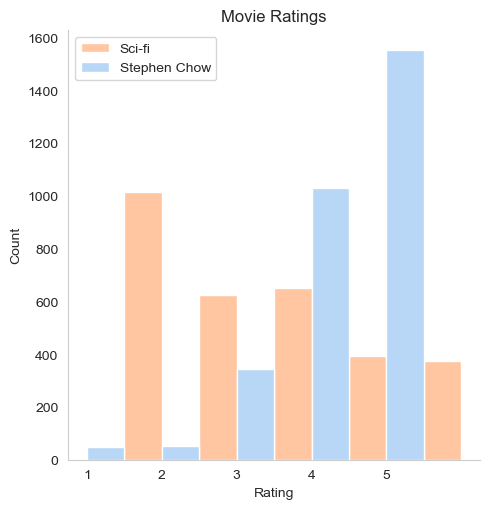

In [13]:
# plot a bar chart to compare the distributions of ratings of the two genres:
sns.set_style("whitegrid", {'axes.grid' : False})
sns.displot(df_merge, x='rating', bins = [1,2,3,4,5,6],palette= 'pastel' , hue='scifi', multiple='dodge', legend=False)
plt.title('Movie Ratings')
plt.xlabel('Rating')
plt.xticks(ticks = [1, 2, 3, 4, 5])
plt.legend(labels=['Sci-fi','Stephen Chow'])
plt.show()

- It is noticed that **Sci-fi Movies** have more lower ratings with a lot falling below "3 stars", and "1 star" is mostly rated. **Stephen Chow Movies** outperform significantly with a large mojority of "4 stars" or "5 stars".  

#### Explore the lengths of the comments for the two genres:

In [14]:
# add a new column 'comment_length' which is the length of the word count in 'comment':
df_merge['comment_length'] = df_merge['comment'].map(len)

Text(0.5, 1.0, 'Movies Comment Lengths')

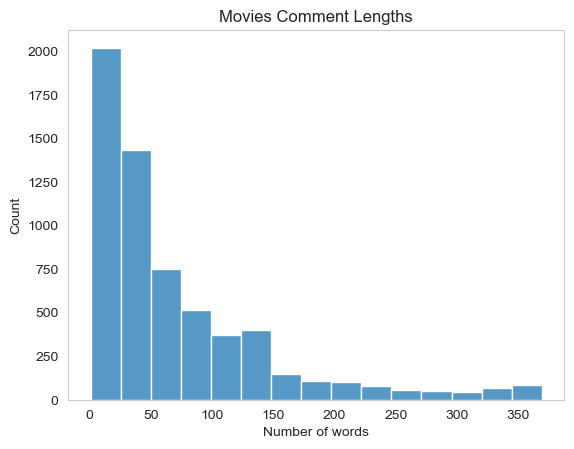

In [15]:
# plot histogram charts to look at the distribution of comment lengths:
sns.histplot(data=df_merge, x='comment_length', bins=15)
plt.xlabel('Number of words')
plt.title('Movies Comment Lengths')

- Apparently not many Chinese audience on Douban leave comments for longer than 100 words. Very few write more than 350 words. 

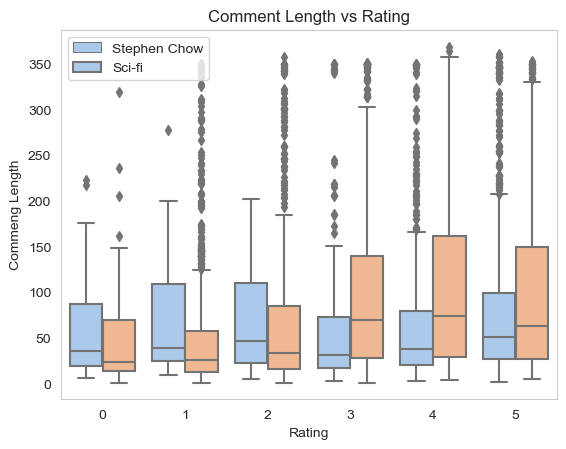

In [16]:
# let's plot a chart to understand if there's any correlation between Comment Lengths and Ratings:
sns.boxplot(data=df_merge, x='rating', y='comment_length', hue='scifi', palette= 'pastel', dodge=True)
plt.title('Comment Length vs Rating')
plt.ylabel('Commeng Length')
plt.xlabel('Rating')
plt.legend(labels=['Stephen Chow', 'Sci-fi'])

- The comments for **Stephen Chow Movies" seem to be shorter than those for **Sci-fi Movies**. It is interesting to see that even not many **Sci-fi Movies** have higher ratings like 4 or 5 stars, but their comments are longer.

#### To proceed further with text data EDA, it is important to tokenise the words and remove the non-essential characaters using a stopwords library:

In [17]:
# get the stopwords dictionary in Chinese:
stopwords_list = stopwords(["zh"])

In [18]:
# to update the dictionary with identifier words to avoid overfitting, meaningles characters that may create too much "noise" for our model:

stopwords_list.update(['电影', '科幻', '科幻片', '科幻电影', '周星驰', '星驰', '喜剧', 'p', 's', 'o', 'beggar', 'King', 'P', 'Chinese Odyssey', 'u', 
                       '张柏芝', 'ly', '吴孟达', '月光宝盒', '大话西游', '流浪', 'sobertipsy', '大话西游大圣娶亲',
                      'N', 'ps', 'movie', 'Beggars', '星爷', '紫霞', '至尊宝', '真的', '搞笑','这部','一部','看过', '觉得',
                      '喜剧之王','刘镇伟','poisonchaser poisonchaser', '大圣娶亲','片子','功夫','没有','imdb链接', '美麗', '张敏', '2', '好 美麗', '丐'])

In [19]:
# tokenise words using jieba.cut:
df_scifi['text'] = df_scifi['comment'].apply(lambda x: ' '.join(jieba.lcut(x)))
df_chow['text'] = df_chow['comment'].apply(lambda x: ' '.join(jieba.lcut(x)))
df_merge['text'] = df_merge['comment'].apply(lambda x: ' '.join(jieba.lcut(x)))

# remove the stopwords:
df_scifi['text'] = df_scifi['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords_list]))
df_chow['text'] = df_chow['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords_list]))
df_merge['text'] = df_merge['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords_list]))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\daphn\AppData\Local\Temp\jieba.cache
Loading model cost 0.659 seconds.
Prefix dict has been built successfully.


#### How do we find out which are the "keywords" in earch genre?

In [20]:
# combine all comments for each title into a long string:
all_text_scifi = df_scifi['text'].str.cat()
all_text_chow = df_chow['text'].str.cat() 

In [21]:
# get the weightage of the top 10 key words using jieba.analyse:
keywords_scifi = jieba.analyse.extract_tags(all_text_scifi, topK=10, withWeight=True, allowPOS=())
keywords_scifi

[('特效', 0.10993846733892),
 ('剧情', 0.07203104937024299),
 ('地球', 0.0588730885545254),
 ('煽情', 0.03766718486541707),
 ('机甲', 0.029821721725491444),
 ('故事', 0.0294702352394554),
 ('中国', 0.02944237386552545),
 ('烂片', 0.02497649857925215),
 ('鹿晗', 0.024697185236496257),
 ('演技', 0.024117311131871856)]

In [22]:
keywords_chow = jieba.analyse.extract_tags(all_text_chow, topK=10, withWeight=True, allowPOS=())
keywords_chow

[('经典', 0.0726319540550061),
 ('无厘头', 0.046703846135995125),
 ('喜欢', 0.036096725131715156),
 ('爱情', 0.028349287762256845),
 ('台词', 0.02645135198938162),
 ('小时候', 0.026213310020741936),
 ('剧情', 0.024658571604482454),
 ('故事', 0.02408911879548752),
 ('我养', 0.02352632273851288),
 ('好看', 0.02203815632959322)]

- To note the weightage here in TextRank for each token is based on its connectivity to other tokens. The same way how PageRank works for Google!

#### It is fun to visualise my text data!

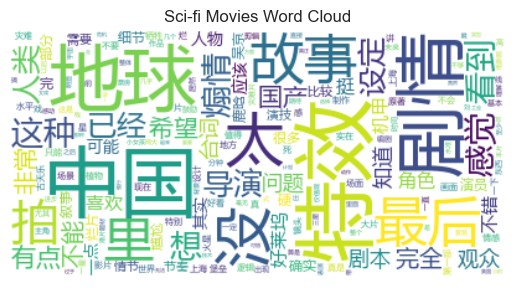

In [23]:
# plot a word cloud the visualise the words with high frenquency:
wc_scifi = WordCloud(font_path="msyh.ttc", background_color="white").generate(str(all_text_scifi))
plt.imshow(wc_scifi, interpolation="bilinear")
plt.axis("off")
plt.title("Sci-fi Movies Word Cloud")
plt.show()

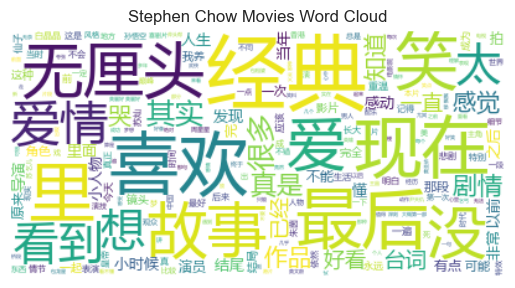

In [24]:
wc_chow = WordCloud(font_path="msyh.ttc", background_color="white").generate(str(all_text_chow))
plt.imshow(wc_chow, interpolation="bilinear")
plt.axis("off")
plt.title("Stephen Chow Movies Word Cloud")
plt.show()

- Word Cloud is certainly visually appealing, but only carries one dimention that is the text density. The colour is for aesthetics only, at least for this one I used. There are other Word Clouds that assign meanings to the colours.

#### Text sentiment analysis using SnowNLP:

In [25]:
# instantiate a list of sentiment score:
s = []

# use for-loop to iterate through the comments and assign a value of the sentiment score to the empty list:
for c in df_merge['comment']:
    score = SnowNLP(c).sentiments
    
    # the scores in the bag of words are in between 0-1, 0 being very negative and 1 being very positive. 
    # to transform the score to a scale of 0-5, 5 being very positive and 1 being very negative:
    if score>=0.95:
        s.append(5)
    elif score>=0.8:
        s.append(4)
    elif score>=0.6:
        s.append(3)
    elif score>=0.5:
        s.append(2)
    else:
        s.append(1)
df_merge['text_sentiment'] = s

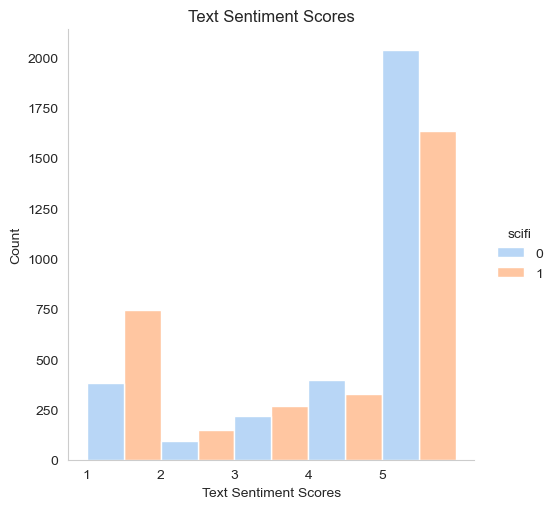

In [26]:
# plot the sentiment scores
sns.set_style("whitegrid", {'axes.grid' : False})
sns.displot(df_merge, x='text_sentiment', bins = [1,2,3,4,5,6],palette= 'pastel' , hue='scifi', multiple='dodge')
plt.xticks([1, 2, 3, 4, 5])
plt.xlabel('Text Sentiment Scores')
plt.title('Text Sentiment Scores')
plt.show()

- SnowNLP sentiment analysis uses a pre-determined bag of words to assign sentiment values for each token in the text data. With the visualised sentiment scores above, it is noticed that most of the text are categorised as "Positive" in tone. This may not be an accurate tool to predict the genuine feedback of a movie.

#### Words can be measured in different dimensions like connectivity, density and tone. We can use Scattertext to visualise text data with higher dimensions.

In [27]:
# instantiate the module:
nlp = zh_core_web_sm.load()

In [28]:
# define the corpus of the words based on the genre:
corpus = st.CorpusFromPandas(df_merge, category_col='scifi', text_col='text', nlp=nlp).build()

In [29]:
# plot the scattertext chart based on the genre:
html = st.produce_scattertext_explorer(corpus, category='1', category_name='Sci-fi', not_category_name='Stephen Chow',
                                      width_in_pixels=1000)
open("scattertext_genre.html",'wb').write(html.encode('utf-8')) # note: The scattertext plot is saved as an html file

3118303

- Below is a screenshot of the html file for reference:

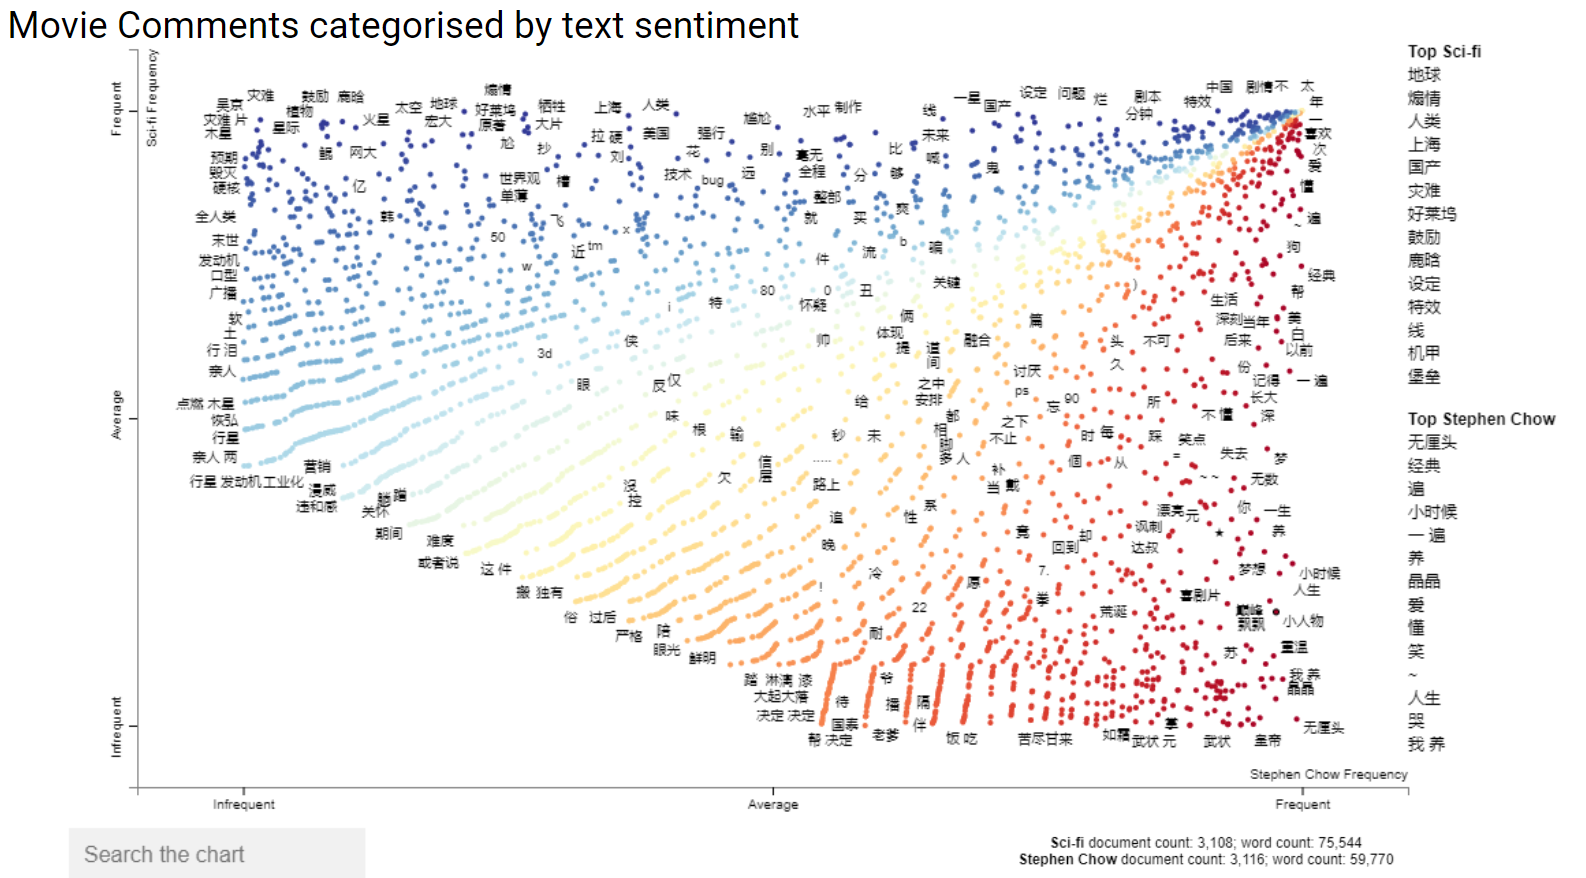

- It is essentially 3 parts we are looking at when reading a scattertext plot:
1. The axises representing two dimensions of the text data. In this case for instance, words are ploted based on genre and frequency;
2. The midline separating the two categories in the centre. This chart is cut in between based on the genre classfication, being "Sci-fi" or "Stephen Chow" movies.
3. The distance between any two words are measured based on the given dimensions. 

#### And It can be transfered using Tf-idf vectorizer, which effectively flatterns higher dimensions of the text data:

In [30]:
# create a parse column:
df_merge['parse'] = df_merge['text'].apply(st.whitespace_nlp_with_sentences)

In [31]:
# define a new corpus based on the genre and parse:
corpus2 = st.CorpusFromParsedDocuments(
    df_merge, category_col='scifi', parsed_col='parse'
).build().get_unigram_corpus().compact(st.AssociationCompactor(1000))

In [32]:
# vectorize the words based on the new corpus, transform them using 2-d projection:
embeddings = TfidfTransformer().fit_transform(corpus2.get_term_doc_mat())
corpus2.get_num_docs()
corpus2.get_num_terms()
embeddings = embeddings.T

U, S, VT = svds(embeddings, k=3, maxiter=20000, which='LM')
print(U.shape, S.shape, VT.shape)

x_dim=0
y_dim=1

projection = pd.DataFrame({'term':corpus2.get_terms(),'x':U.T[x_dim],'y':U.T[y_dim]}).set_index('term')
projection

(998, 3) (3,) (3, 6240)


x         y
term                    
泪    -0.011141  0.008782
这句   -0.003544  0.004333
真是   -0.023127  0.028990
不能    0.013900 -0.019574
哈哈哈  -0.009279  0.020206
...        ...       ...
七彩   -0.001002  0.003974
猜不着  -0.000615  0.002033
七色   -0.000762  0.002843
云彩   -0.000704  0.002190
金甲   -0.000840  0.002262

[998 rows x 2 columns]

In [33]:
# plot the scattertext again with reduced dimensions:
html = st.produce_pca_explorer(corpus2,
                              category='1',
                              category_name='Sci-fi',
                              not_category_name='Stephen Chow',
                              projection=projection,
                              width_in_pixels=2000,
                              scaler = st.scale_neg_1_to_1_with_zero_mean,
                              x_dim=x_dim,
                              y_dim=y_dim)
open('scattertext_genre_tfidf.html','wb').write(html.encode('utf-8'))

2431910

- Below is a screenshot of the html file for reference:

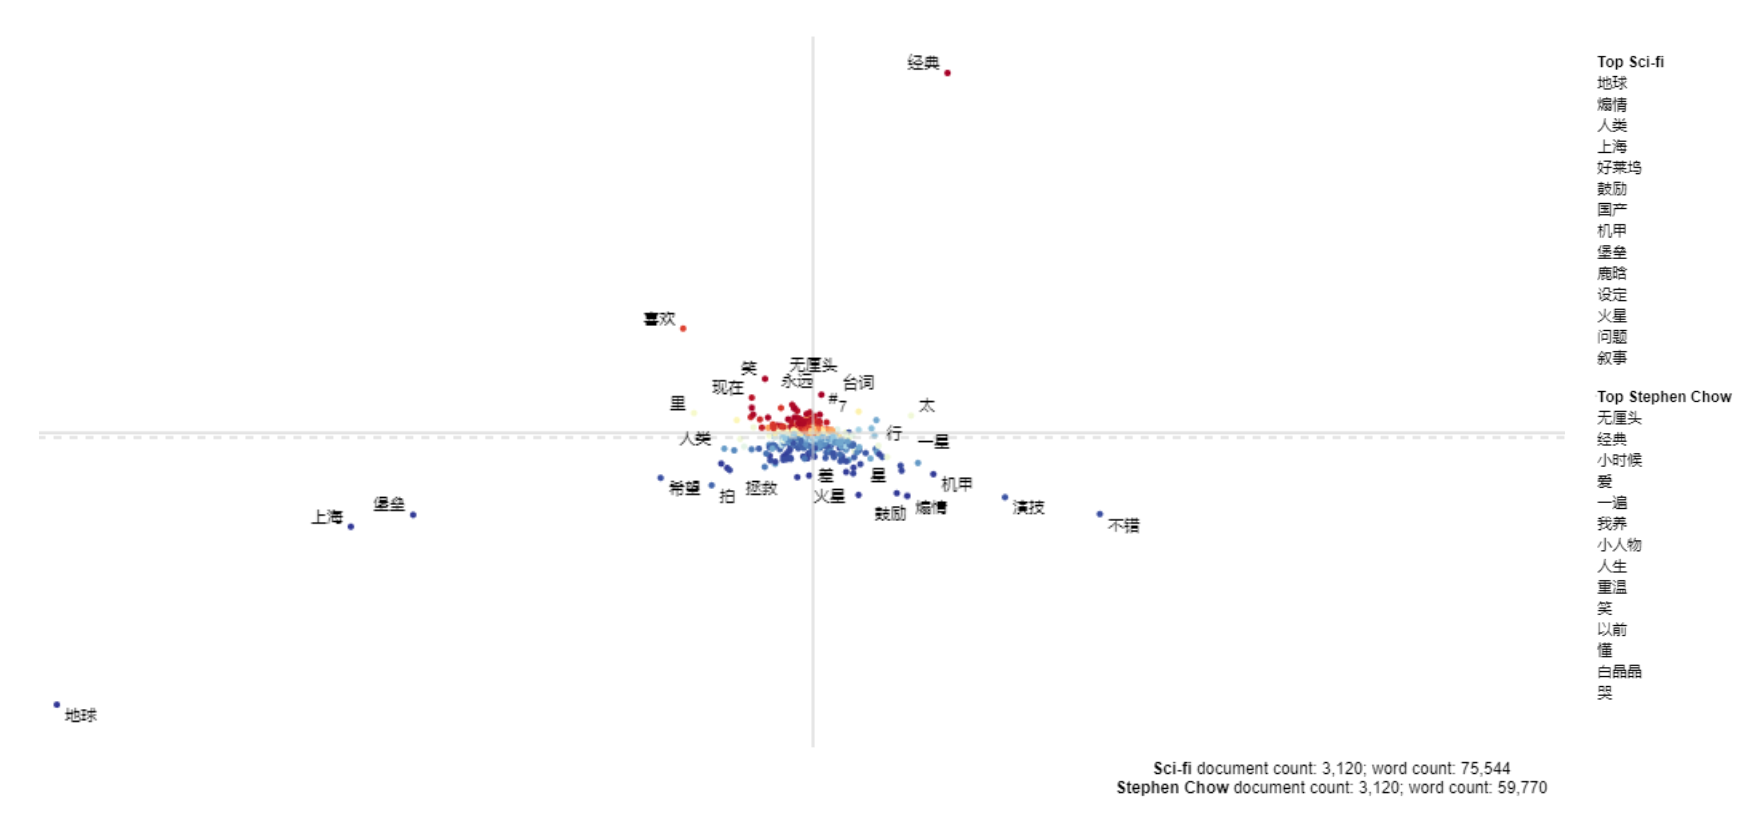

- This is another plot using Tf-idf Vectorizer as the transformer for the text data.
- It is noticed that only keywords chosen by Tf-idf Vectorizer are displayed, and the distance between the words are illustrated in a clear way.
- Looking at the chart makes me feel the tool actually understands Chinese language. :) 

## Preprocessing & Modeling

In [34]:
# set up our data for modeling:
X = df_merge['text']
y = df_merge['scifi']

In [35]:
# check what we need to check for classification:
y.value_counts(normalize = True)

1    0.5
0    0.5
Name: scifi, dtype: float64

In [36]:
# split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.22,
                                                    stratify=y,
                                                    random_state=42)

#### Baseline: If we predict all comments are Sci-fi Movies, what is the chance of getting it correct?

In [37]:
y_test.value_counts(normalize=True)

0    0.500364
1    0.499636
Name: scifi, dtype: float64

- The accuracy of the basemodel is about 50.0%.

#### Model A: CountVectorizer with Multinomial Naive Bayes:

**CountVectrizer** converts a text corpus into a sparse matrix where each row represents a document and each column represents a specific word in the corpus, and the values represent the count of that word in that particular document. Some Pros of CountVectorizer include:
- It is a simple and efficient way to convert text into numerical representations that can be used for machine learning models.
- It can handle large amounts of text data and is scalable.

**Naïve Bayes** makes the assumption that all features are independent of one another. Despite this assumption not being realistic with NLP data, we still use Naïve Bayes pretty frequently. Pros are:
- It's a very fast modeling algorithm (which is great especially when we have lots of features and/or lots of data!). 
- It is often an excellent classifier, outperforming more complicated models.

In [38]:
# instantiate the model:
cvec = CountVectorizer(max_features = 1000)
nb = MultinomialNB()

In [39]:
# fit and transform:
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train).todense(),
                          columns = cvec.get_feature_names_out())
X_test_cvec= pd.DataFrame(cvec.transform(X_test).todense(),
                         columns = cvec.get_feature_names_out())

In [40]:
# fit and predict with NB modeL:
model_nb = nb.fit(X_train_cvec, y_train)
pred_nb = model_nb.predict(X_test_cvec)

In [41]:
# Define a function to evaluate the model based on different metrics:

def metric_printer(model, model_name, Xtrain, ytrain, Xtest, ytest):
    # list the metrics that we will evaluate based upon:
    train_score = model.score(Xtrain, ytrain)
    test_score = model.score(Xtest, ytest)
    preds = model.predict(Xtest)
    roc = roc_auc_score(ytest, preds)
    recall = recall_score(ytest, preds)
    precision = precision_score(ytest, preds)
    f_score = f1_score(ytest, preds)
    
    # plot a figure with two columns to contain both confusion matrix and barplot of metrics:
    figs, axs = plt.subplots(ncols=2, figsize=(15,5))
    figs.suptitle(model_name, fontsize=10)
    
    # plot confusion matrix on the left hand:
    ConfusionMatrixDisplay.from_predictions(ytest, preds, ax=axs[0], cmap='Greys', display_labels=['Scifi', 'Stephen Chow'])

    # plot a barplot of metrics on the right
    labels = ['Test Accuracy', 'Train Accuracy',  'ROC-AUC Score', 'Recall', 'Precision', 'F1 Score']
    values = [test_score, train_score, roc, recall, precision, f_score]
    axs[1].barh(labels, values, color='grey')
    for i, value in enumerate(values):
        axs[1].text(value, i, str(round(value*100,1)) + '%', ha='left', fontsize=10)
    axs[1].grid(False)    
    return confusion_matrix(ytest, preds)

array([[596,  91],
       [ 45, 641]], dtype=int64)

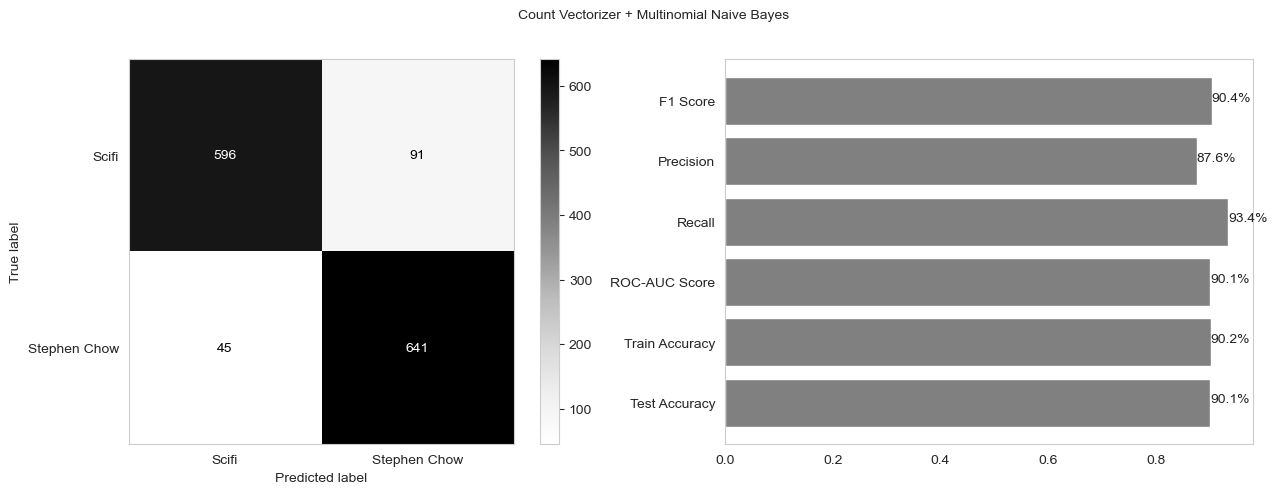

In [42]:
# print the model metric
metric_printer(model_nb, 'Count Vectorizer + Multinomial Naive Bayes', X_train_cvec, y_train, X_test_cvec, y_test)

#### Model B: TD-IDF Vectorizer with Logistic Regression:

**TD-IDF Vectorizer** as compared to CountVectorizer, assigns an importance weightage to words. Other than that, some other Pros of using TD-IDF Vectorizer include:

- It handles stop words more effectively by assigning a low weightage to less meaningful words. This improves the model accuracy.
- It is suitable to be used for large datasets due to its computational efficiency.
- It is well used for classification models as it captures the importance of each feature.

**Logistic Regression**, as it suggests by its name, is widely used in binary classification problems. Some Pros are:

- It is a simple model that helps understand the input and output viarables easily.
- It is an efficient model to work on large datasets.
- The results are easy to interprete.

#### When I designed Model B, I had the assumption it would outperform Model A due to the fact that:

- TD-IDF would be able to assign the importance to the features, but CountVectorizer only takes in the feature's frequency.
- Naive Bayes assumes independence of each feature that it takes. It might not be able to understand the contextual connections and linguistic complexity especially for Chinese.

In [43]:
# instantiate the model:
tvec = TfidfVectorizer(max_features=1000)
lg = LogisticRegression()

In [44]:
# retrieve the train and test data again:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.22,
                                                    stratify=y,
                                                    random_state=42)

In [45]:
# fit and transform:
X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train).todense(),
                          columns = tvec.get_feature_names_out())
X_test_tvec= pd.DataFrame(tvec.transform(X_test).todense(),
                         columns = tvec.get_feature_names_out())

In [46]:
# fit and predict with LG model:
model_lg = lg.fit(X_train_tvec, y_train)
pred_lg = model_lg.predict(X_test_cvec)

array([[632,  55],
       [106, 580]], dtype=int64)

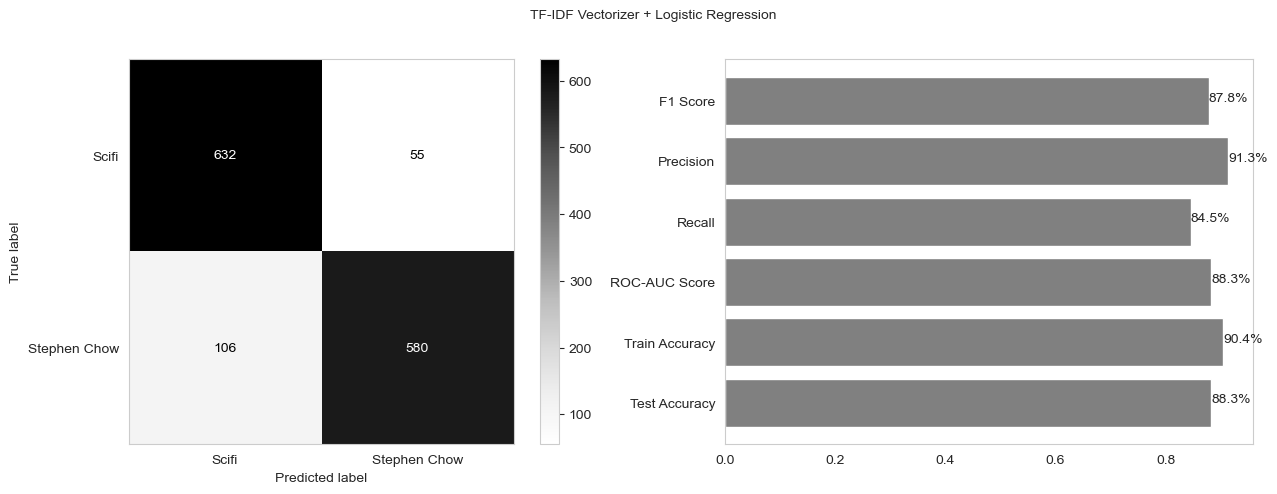

In [47]:
# print the model metrics:
metric_printer(model_lg, 'TF-IDF Vectorizer + Logistic Regression', X_train_cvec, y_train, X_test_cvec, y_test)

- Below is a table illustrating the comparison of metrics for Model A and B.

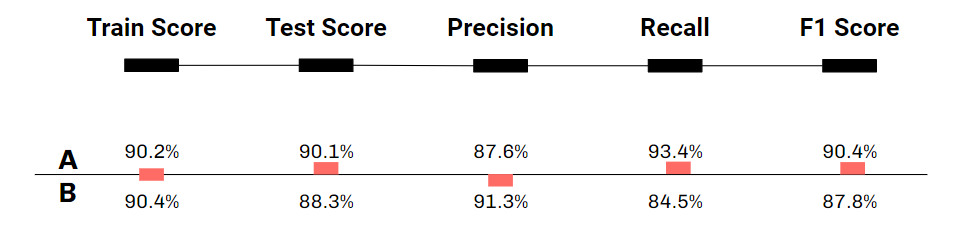

#### Use ROC AUC Curve to verify the model performances:

Text(0.5, 1.0, 'ROC AUC Comparison')

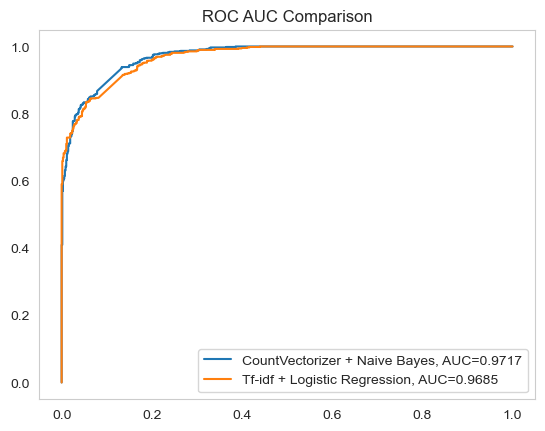

In [48]:
# set up plotting area
plt.figure(0).clf()

# CV + NB:
pred_nb = model_nb.predict_proba(X_test_cvec)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, pred_nb)
auc = round(metrics.roc_auc_score(y_test, pred_nb), 4)
plt.plot(fpr,tpr,label="CountVectorizer + Naive Bayes, AUC="+str(auc))

# Tf-idf + LG:
pred_lg = model_lg.predict_proba(X_test_tvec)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, pred_lg)
auc = round(metrics.roc_auc_score(y_test, pred_lg), 4)
plt.plot(fpr,tpr,label="Tf-idf + Logistic Regression, AUC="+str(auc))

# add legend
plt.legend()
plt.title("ROC AUC Comparison")

- Model A outperforms model B for most of the metrics with precision as an exception. 
- Precision is the fraction of true positive predictions (correctly predicted positive instances) among all predicted positive instances. In general, increasing the threshold for predicting a positive class will lead to higher precision but lower recall. This is because when we increase the threshold, we are making the model more conservative in predicting the positive class, which leads to fewer false positives, and hence higher precision.
- In some cases, in a fraud detection task, high precision may be more important to avoid falsely flagging any negative instances. But for the purpose of study, we are not specifically aiming for high precision and hence will pick Model A with a better performance in general.

#### How do we interprete the model coefficients?

In [49]:
# extract the keywords of movie comments and the corresponding probabilities:
chow_keywords = pd.DataFrame(data=[cvec.get_feature_names_out(), 
                                     np.exp(nb.feature_log_prob_[0])], 
                                     index=['word', 'prob'])
chow_keywords = chow_keywords.T.sort_values('prob', ascending=False)

scifi_keywords = pd.DataFrame(data=[cvec.get_feature_names_out(), 
                                     np.exp(nb.feature_log_prob_[1])], 
                                     index=['word', 'prob'])
scifi_keywords = scifi_keywords.T.sort_values('prob', ascending=False)

In [50]:
# get the top 10 words:
chow_keywords = chow_keywords.head(10)
scifi_keywords = scifi_keywords.head(10)

In [51]:
# sort the keywords based on the coefficients:
chow_keywords = chow_keywords.sort_values(by= 'prob', ascending=True)
scifi_keywords = scifi_keywords.sort_values(by= 'prob', ascending=True)

Text(0.5, 1.0, 'Top 10 words with high correlation to Sci-fi Movie')

C:\Users\daphn\Miniconda3\envs\dsi-sg\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 24456 (\N{CJK UNIFIED IDEOGRAPH-5F88}) missing from current font.
  func(*args, **kwargs)
C:\Users\daphn\Miniconda3\envs\dsi-sg\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 22810 (\N{CJK UNIFIED IDEOGRAPH-591A}) missing from current font.
  func(*args, **kwargs)
C:\Users\daphn\Miniconda3\envs\dsi-sg\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from current font.
  func(*args, **kwargs)
C:\Users\daphn\Miniconda3\envs\dsi-sg\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  func(*args, **kwargs)
C:\Users\daphn\Miniconda3\envs\dsi-sg\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 20505 (\N{CJK UNIFIED IDEOGRAPH-5019}) missing from current font.
  func(*args, **kwargs)
C:\Users\daphn\Miniconda3\envs\dsi-sg\li

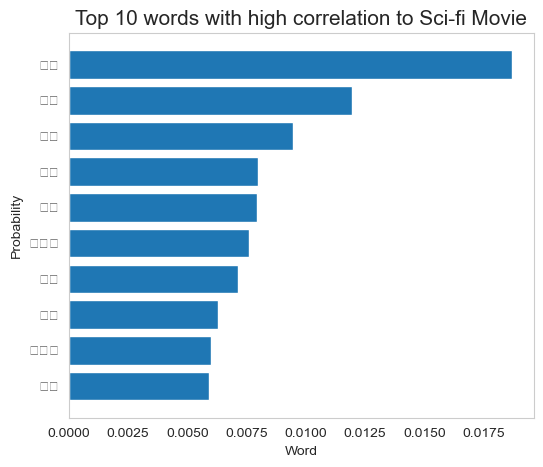

In [52]:
# plot a bar chart to show the top 10 words
plt.figure(figsize=(6,5))
plt.barh(y=chow_keywords['word'], width=chow_keywords['prob'])
plt.xlabel('Word')
plt.ylabel('Probability')
plt.title('Top 10 words with high correlation to Sci-fi Movie', fontsize=15)

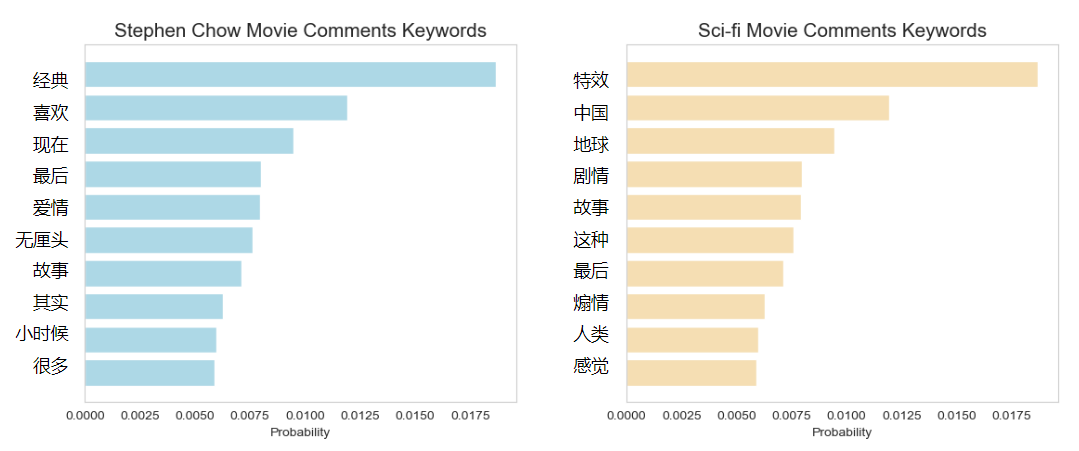

## Prediction

In [53]:
# output the predictions into a dataframe:
df_pred = pd.DataFrame(model_nb.predict(X_test_tvec), index=y_test.index)
# change the column name to reflect the target variables:
df_pred.rename(columns={0: 'predicted'}, inplace=True)

In [54]:
# retrieve the actual target variables:
df_ytest= pd.DataFrame(y_test)

In [55]:
# combine both predicted and actual target variables into the same dataframe:
df_compare = pd.concat([df_pred, df_ytest], axis=1)

In [56]:
# slice the misclassified entries:
df_compare.loc[df_compare['predicted']!=df_compare['scifi']]

predicted  scifi
318          0      1
119          0      1
492          0      1
161          0      1
105          1      0
..         ...    ...
144          0      1
295          1      0
127          0      1
155          1      0
210          1      0

[144 rows x 2 columns]

In [57]:
# discover examples of misclassified comments:
df_merge.iloc[318,:]['comment']

'尬到骨髓。'

- This is a way too short comment that does not offer much contextual value. It is not easy for the model to detect the classification.

In [58]:
df_merge.iloc[105,:]['comment']

'摒除当下“保护主义”盛行所附加的“降低标准”、“一星鼓励”，这就是个三星偏低水准的作品。制作层面在当下中国电影工业而言是很亮眼的，大概达到了好莱坞二十年前的水平。剧本故事完整，三幕结构加双线，很标准的路数，最大的欠缺是人物扁平，没有能让人记住的角色，（演员表现比较糟糕）也让整部片子显得有些闷。导演很粗暴也很潦草，“饱满”的配乐听上去大都是高仿的美国货，鼓点都差不多，当然这都是行业惯例，不过直男煽情还是得多练习一下。最后从科幻层面而言，这部片子“硬科幻”定义的有待商榷。'

- This comment is long enough to provide more contextual value. But it contains too many big words with rich cultural references. The model may not be able to capture the subtle sementics in the comment.

## Conclusion and Recommendation

#### Conclusion:

While NLP can certainly be used to analyze the linguistic complexity of Chinese, it may not be as effective in uncovering all of the cultural nuances of the language. This is because:

- Chinese is a tonal language, which means that a single word can have multiple meanings depending on the tone in which it is spoken.
- Cultural references to literature can also be challenging for NLP systems to comprehend.

#### Recommendation for Douban:

The use of NLP model for content review or content recommendation system is helpful to a large extent given the accuracy of the model.
It is important to consider the limitations of NLP when analyzing Chinese, and to supplement these analyses with cultural context and human interpretation.

## References:

- https://medium.com/@jjsham/nlp-tokenizing-chinese-phases-3302da4336bf
- https://stackoverflow.com/questions/2718196/find-all-chinese-text-in-a-string-using-python-and-regex
- https://medium.com/the-artificial-impostor/preview-developing-modern-chinese-nlp-models-60d4774ebfa7
- https://zhuanlan.zhihu.com/p/27198713
- https://towardsdatascience.com/chinese-natural-language-pre-processing-an-introduction-995d16c2705f
- https://towardsdatascience.com/beginners-guide-to-sentiment-analysis-for-simplified-chinese-using-snownlp-ce88a8407efb
- https://zhuanlan.zhihu.com/p/273399469
- https://codeantenna.com/a/UbO268F9RD
- https://blog.csdn.net/be_racle/article/details/113829319
- https://www.statology.org/plot-multiple-roc-curves-python/